In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

from scipy.interpolate import interp1d
from scipy.stats import kstest
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, r2_score
from scipy.interpolate import make_interp_spline

In [5]:
valid_guesses = pd.read_csv("valid_guesses_words.csv")
valid_solutions = pd.read_csv("valid_solutions_words.csv")
valid_guesses_cnt = valid_guesses.shape[0]
valid_solutions_cnt = valid_solutions.shape[0]

valid_guesses = valid_guesses["word"].tolist()
valid_solutions = valid_solutions["word"].tolist()

# print(valid_guesses)
# print(valid_solutions)
print(valid_guesses_cnt)
print(valid_solutions_cnt)

2992
341


In [2]:
# 状态列表与状态码相互转换
def status_transform2number(status=[0, 0, 0, 0, 0]):
    res = 0
    a = 1
    for i in status:
        res += a * i
        a = a * 3
    return res

def number_transform2status(number=0):
    res = []
    for i in range(5):
        res.append(number % 3)
        number //= 3
    return res

# 生成合法的状态排列
def generate_status():
    res = []
    for i in range(243):
        cur = []
        x = i
        for j in range(5):
            cur.append(x % 3)
            x //= 3
        res.append(cur)
        
    return res

In [3]:
# 对猜测答案与正确答案之间进行验证
# 状态0代表完全错误，1代表字母正确且位置错误，2代表字母和位置都正确
def validation(guess, solution):
    result = [0, 0, 0, 0, 0]
    guess_list = list(guess)
    solution_list = list(solution)
    solution_letter_remainder = []
    
    for i in range(5):
        if guess_list[i] == solution_list[i]:
            result[i] = 2
        else:
            solution_letter_remainder.append(solution_list[i])
    
    for i in range(5):
        if result[i] == 2:
            continue
        for ch in solution_letter_remainder:
            if guess[i] == ch:
                result[i] = 1
                solution_letter_remainder.remove(ch)
                break
    
    return result

# print( validation("grape", "hello") )
# print( validation("heart", "hello") )
# print( validation("hello", "hello") )

In [7]:
data = pd.read_excel("COCA60000FULL.xlsx")
data["word"] = data["word"].str.replace(' ', '')

data_selected = data[data["word"].str.len() == 5]
word_frequency = data_selected.sort_values(by="TOTAL", axis=0, ascending=True)
word_frequency["frequency"] = word_frequency["TOTAL"] / word_frequency["TOTAL"].sum()
word_frequency

,RANK #,PoS,word,TOTAL,SPOKEN,FICTION,MAGAZINE,NEWSPAPER,ACADEMIC,frequency
57873,57875,J,unhip,18,0,7,4,6,1,4.164350e-07
59267,59269,R,roily,19,0,11,7,0,1,4.395703e-07
58747,58749,J,topsy,19,4,10,2,1,2,4.395703e-07
58806,58808,N,shoat,19,0,14,2,2,1,4.395703e-07
58818,58820,J,homed,19,0,10,4,0,5,4.395703e-07
...,...,...,...,...,...,...,...,...,...,...
55,56,V,think,838695,423892,193081,88312,93525,39885,1.940344e-02
52,53,E,there,846483,301556,155571,135904,139865,113587,1.958362e-02
45,46,I,about,952604,328762,178533,163092,163636,118581,2.203876e-02
40,41,V,would,1000182,251284,257792,166384,178690,146032,2.313949e-02


In [4]:
# 计算信息量（信息熵）
def Entropy(p):
    if p == 0 or p == 1:
        return 0.0
    return - p * np.log(p) - (1.0 - p) * np.log(1.0 - p)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [8]:
x_width = 10
n_common = 3000
c = x_width * (-0.5 + n_common / word_frequency.shape[0])
xs = np.linspace(c - x_width / 2, c + x_width / 2, word_frequency.shape[0])
xs = sigmoid(xs)

word_frequency["word_proability"] = xs
word_frequency["word_proability_entropy"] = word_frequency["word_proability"].apply(Entropy)
word_frequency.to_csv("word_frequency.csv")
word_frequency

,RANK #,PoS,word,TOTAL,SPOKEN,FICTION,MAGAZINE,NEWSPAPER,ACADEMIC,frequency,word_proability,word_proability_entropy
57873,57875,J,unhip,18,0,7,4,6,1,4.164350e-07,0.058522,0.222882
59267,59269,R,roily,19,0,11,7,0,1,4.395703e-07,0.058655,0.223250
58747,58749,J,topsy,19,4,10,2,1,2,4.395703e-07,0.058788,0.223620
58806,58808,N,shoat,19,0,14,2,2,1,4.395703e-07,0.058921,0.223989
58818,58820,J,homed,19,0,10,4,0,5,4.395703e-07,0.059055,0.224360
...,...,...,...,...,...,...,...,...,...,...,...,...
55,56,V,think,838695,423892,193081,88312,93525,39885,1.940344e-02,0.999263,0.006052
52,53,E,there,846483,301556,155571,135904,139865,113587,1.958362e-02,0.999265,0.006039
45,46,I,about,952604,328762,178533,163092,163636,118581,2.203876e-02,0.999267,0.006026
40,41,V,would,1000182,251284,257792,166384,178690,146032,2.313949e-02,0.999268,0.006014


In [9]:
legal_words_in_valid_solutions = pd.read_csv("guess_legal_words_data(valid_solutions).csv")
legal_words_metrics_in_valid_solutions = pd.read_csv("guess_legal_words_metrics_data(valid_solutions).csv")
legal_words_in_valid_guesses = pd.read_csv("guess_legal_words_data(valid_guesses).csv")

legal_words_metrics_in_valid_solutions

,Unnamed: 0,guess,total_entropy,word_frequency,word_proability,word_proability_entropy
0,0,aback,3.138718,4.160000e-07,0.058522,0.222882
1,1,abase,4.069325,4.400000e-07,0.058655,0.223250
2,2,abash,3.711645,4.400000e-07,0.058788,0.223620
3,3,abate,4.173060,4.400000e-07,0.058921,0.223989
4,4,abaya,2.617806,4.400000e-07,0.059055,0.224360
...,...,...,...,...,...,...
2987,2987,zesty,3.638344,6.900000e-05,0.988042,0.064815
2988,2988,zilch,3.564848,6.930000e-05,0.988071,0.064690
2989,2989,zingy,2.875865,6.930000e-05,0.988099,0.064565
2990,2990,zippy,2.278112,6.930000e-05,0.988127,0.064440


In [10]:
# 在单词集中找出符合要求的所有单词
def get_legal_words(guess, status, legal_words_csv):
    result = legal_words_csv[ (legal_words_csv["guess"] == guess) & ( legal_words_csv["number"] == status_transform2number(status) ) ]
    if result.shape[0] == 0:
        return []
    legal_words = result["legal_words"].tolist()[0]
    legal_words = eval(legal_words)
    # print(legal_words)
    return legal_words


# 统计单词集中符合要求的所有单词的数量
def get_legal_words_cnt(guess, status, legal_words_csv):
    legal_words = get_legal_words(guess, status, legal_words_csv)
    return len(legal_words)


# 统计单词集中符合要求的所有单词的信息量（信息熵）
def get_legal_words_entropy(guess, status, legal_words_csv):
    if legal_words_csv.shape[0] == 0:
        return 0.0
    
    p = get_legal_words_cnt(guess, status, legal_words_csv) / legal_words_csv.shape[0]
    if p == 0 or p == 1:
        return 0.0
    
    entropy = Entropy(p)
    return entropy


# 计算总信息量（信息熵）
def get_legal_words_total_entropy(guess, status, legal_words_csv):
    total_status = generate_status()
    total_entropy = 0
    for status in total_status:
        total_entropy += get_legal_words_entropy(guess, status, legal_words_csv)
    return total_entropy


# 获取词汇频率
def get_word_frequency(guess):
    result = word_frequency[ word_frequency["word"] == guess ]
    weight = result["frequency"].tolist()
    res = sum(weight)
    
    # print(res)
    return res

# print( get_word_frequency("hello") )


# 获取词汇出现概率
def get_word_proability(guess):
    result = word_frequency[ word_frequency["word"] == guess ]
    weight = result["proability"].tolist()
    res = sum(weight)
    
    # print(res)
    return res

In [11]:
# 进行一轮猜测
def simple_guess(alpha, beta, legal_words_metrics):
    maximal_weight = 0.0
    cur_guess = ""
    # print("legal_words_metrics:", legal_words_metrics["guess"].tolist())
    
    for i in range(legal_words_metrics.shape[0]):
        row = legal_words_metrics.iloc[i, :]
        guess = getattr(row, "guess")
        total_entropy = getattr(row, "total_entropy")
        word_proability = getattr(row, "word_proability")
        word_proability_entropy = getattr(row, "word_proability_entropy")
        
        # print(guess, end=' ')
        
        cur_weight = alpha * total_entropy + beta * word_proability
        if cur_weight > maximal_weight:
            maximal_weight = cur_weight
            cur_guess = guess
    
    # print()
    return cur_guess

In [12]:
# 进行单场wordle游戏
# alpha和beta分别为信息熵和词频的权重
legal_words_in_valid_solutions
legal_words_metrics_in_valid_solutions
legal_words_in_valid_guesses

def simple_game(solution, alpha=1, beta=1500):
    status = [0, 0, 0, 0, 0]
    times = 6
    current_legal_words_metrics = legal_words_metrics_in_valid_solutions
    # print(current_legal_words_metrics)
    
    for i in range(times):
        
        # print("current_legal_words_metrics:", current_legal_words_metrics["guess"].tolist())
        cur_guess = simple_guess(alpha, beta, current_legal_words_metrics)
        # print("cur_guess:", cur_guess)
        
        if len(cur_guess) == 0:
            return 7
        status = validation(cur_guess, solution)
        if status_transform2number(status) == 242:
            return i + 1
        
        guess_legal_words_list = get_legal_words(cur_guess, status, legal_words_in_valid_guesses)
        current_legal_words_metrics = current_legal_words_metrics[ current_legal_words_metrics["guess"].isin(guess_legal_words_list) ]
    
    return 7

simple_game("eerie")

5

In [13]:
# 以solution_list集里的所有单词作为答案，运行一次wordle游戏
# 一轮平均2-3min
def enumerate_solutions(alpha, beta, guess_list=valid_guesses, solution_list=valid_solutions):
    # results = []
    words = []
    nums = []
    # print("enumerate_solutions")
    # print("alpha =", alpha, "beta =", beta)
    
    for word in solution_list:     
        times = simple_game(word, alpha, beta)
        # results.append([word, times])
        words.append(word)
        nums.append(times)
        # print("result = ", [word, times])
        
    return [words, nums]

# results = enumerate_solutions(0.5, 5.5)

In [235]:
parameters_with_mean = []
for i in range(1500, 2000):
    continue
    k = i
    results = enumerate_solutions(1, k)
    
    words = results[0]
    nums = results[1]
    results = []
    for i in range( len(words) ):
        results.append([words[i], nums[i]])
    mean = sum(nums) / len(nums)
    parameters_with_mean.append([k, mean])
    print("k =", k, "mean =", mean)
    
    # enumerate_solutions_results = pd.DataFrame(results, columns=["word", "guess_times"])
    # enumerate_solutions_results.to_csv("enumerate_solutions_results.csv")
    
# parameters_with_mean_df = pd.DataFrame(parameters_with_mean, columns=["multiply", "mean"])
# parameters_with_mean_df.to_csv("parameters_with_mean.csv")
# parameters_with_mean_df

In [97]:
k = 1500
results = enumerate_solutions(1, k)

words = results[0]
nums = results[1]
results = []
for i in range( len(words) ):
    results.append([words[i], nums[i]])
mean = sum(nums) / len(nums)
parameters_with_mean.append([k, mean])
print("k =", k, "mean =", mean)

enumerate_solutions_results = pd.DataFrame(results, columns=["word", "guess_times"])
enumerate_solutions_results.to_csv("enumerate_solutions_results.csv")

In [99]:
enumerate_solutions_results = pd.read_csv("enumerate_solutions_results.csv")
nums = enumerate_solutions_results["guess_times"].tolist()

x=[1,2,3,4,5,6,7]
y=[0,0,0,0,0,0,0]

for i in nums:
    y[i-1] += 1

print(y)
total = sum(y)
guess_times_frequency = [i / total for i in y]
print(guess_times_frequency)

[0, 10, 74, 133, 88, 27, 9]
[0.0, 0.02932551319648094, 0.21700879765395895, 0.39002932551319647, 0.25806451612903225, 0.07917888563049853, 0.026392961876832845]


In [278]:
def get_guess_word_uncertain_entropy(guess):
    eerie_expect_guess_times = []
    for k in range(1500 - 50, 1500 + 50 + 1):
        result = simple_game(guess, 1, k)
        eerie_expect_guess_times.append(result)
    
    x = [1,2,3,4,5,6,7]
    y = [0,0,0,0,0,0,0]

    for i in eerie_expect_guess_times:
        y[i - 1] += 1
    
    total_entropy = 0
    for i in range(7):
        total_entropy += Entropy( y[i] / sum(y) )
    return total_entropy

In [291]:
enumerate_solutions_results = pd.read_csv("enumerate_solutions_results.csv")
enumerate_solutions_results = enumerate_solutions_results.sort_values(by="guess_times")
random_slice = [random.randrange(0, 341) for x in range(20)]
enumerate_solutions_results = enumerate_solutions_results.loc[random_slice, :]
enumerate_solutions_results

results = []
for guess in enumerate_solutions_results["word"].tolist():
    cur = get_guess_word_uncertain_entropy(guess)
    results.append(cur)
    
ave = sum(results) / len(results)
ave

0.0

In [292]:
print( shapiro(guess_times_frequency) )

ShapiroResult(statistic=0.8824514150619507, pvalue=0.2375536859035492)


In [298]:
data = eerie_expect_guess_times

mean = np.mean(data)
var = np.var(data)
n = len(data)
alpha = 0.05    # 显著性水平
z_alpha = 1.96

l, r = mean - 1.0 / np.sqrt(n) * z_alpha, mean + 1.0 / np.sqrt(n) * z_alpha
print(f"[{l}, {r}]")

x = [1,2,3,4,5,6,7]
y = [0,0,0,0,0,0,0]
tot = 0

for i in data:
    y[i - 1] += 1
    tot += 1
for i in range(7):
    y[i] /= tot
    
print(y)

[4.816976139888729, 5.093471621305301]
[0.0, 0.0, 0.0, 0.04477611940298507, 0.9552238805970149, 0.0, 0.0]


In [299]:
eerie_expect_guess_times_csv = pd.DataFrame(eerie_expect_guess_times, columns=["eerie_guess_times"])
eerie_expect_guess_times_csv.to_csv("eerie_expect_guess_times.csv")

In [92]:
valid_solutions_words_csv = pd.read_csv("valid_solutions_words.csv")
valid_solutions_words_csv

def get_guess_times_average(guess, l = 1400, r = 1600):
    check = valid_solutions_words_csv[ valid_solutions_words_csv["word"] == guess ]
    if check.shape[0] == 0:
        return "illegal input"
    
    guess_times = []
    for k in range(l, r + 1):
        result = simple_game(guess, 1, k)
        guess_times.append(result)
    
    guess_times = np.array(guess_times)
    return guess_times, guess_times.mean()

guess_times, mean = get_guess_times_average("eerie")
guess_times_csv = pd.DataFrame(guess_times, columns=["guess_times"])
guess_times_csv.to_csv("eerie_guess_times(5).csv")

In [160]:
_, mean = get_guess_times_average("judge")
mean

KeyboardInterrupt: 

In [30]:
Problem_C_Data_Wordle = pd.read_excel("Problem_C_Data_Wordle.xlsx", header=1)
Problem_C_Data_Wordle = Problem_C_Data_Wordle.drop(["Unnamed: 0"], axis=1)
Problem_C_Data_Wordle = Problem_C_Data_Wordle.sort_values(by="Date", axis=0, ascending=True)

Problem_C_Data_Wordle["total_percent"] = Problem_C_Data_Wordle.iloc[:, 5:12].sum(axis=1)

Problem_C_Data_Wordle["real_difficulty"] = Problem_C_Data_Wordle.iloc[:, 5] * 1 + Problem_C_Data_Wordle.iloc[:, 6] * 2 + \
                        Problem_C_Data_Wordle.iloc[:, 7] * 3 + Problem_C_Data_Wordle.iloc[:, 8] * 4 + \
                        Problem_C_Data_Wordle.iloc[:, 9] * 5 + Problem_C_Data_Wordle.iloc[:, 10] * 6 + Problem_C_Data_Wordle.iloc[:, 11] * 7 
Problem_C_Data_Wordle["real_difficulty"] = Problem_C_Data_Wordle["real_difficulty"] / Problem_C_Data_Wordle.iloc[:, 12]
# data.sort_values(by="real_difficulty", axis=0, ascending=True)

Problem_C_Data_Wordle

,Date,Contest_number,Word,Number_of_reported_results,Number_in_hard_mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),total_percent,real_difficulty
358,2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,1,100,4.130000
357,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2,100,4.220000
356,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4,100,4.640000
355,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2,100,4.430000
354,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1,101,3.732673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,100,4.450000
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,99,4.191919
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,100,4.400000
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,99,4.181818


In [122]:
Problem_C_Data_Wordle = pd.read_excel("Problem_C_Data_Wordle.xlsx", header=1)
Problem_C_Data_Wordle = Problem_C_Data_Wordle.drop(["Unnamed: 0"], axis=1)
Problem_C_Data_Wordle = Problem_C_Data_Wordle.sort_values(by="Date", axis=0, ascending=True)

Problem_C_Data_Wordle["total_percent"] = Problem_C_Data_Wordle.iloc[:, 5:12].sum(axis=1)

Problem_C_Data_Wordle["real_difficulty"] = Problem_C_Data_Wordle.iloc[:, 5] * 1 + Problem_C_Data_Wordle.iloc[:, 6] * 2 + \
                        Problem_C_Data_Wordle.iloc[:, 7] * 3 + Problem_C_Data_Wordle.iloc[:, 8] * 4 + \
                        Problem_C_Data_Wordle.iloc[:, 9] * 5 + Problem_C_Data_Wordle.iloc[:, 10] * 6 + Problem_C_Data_Wordle.iloc[:, 11] * 7 
Problem_C_Data_Wordle["real_difficulty"] = Problem_C_Data_Wordle["real_difficulty"] / Problem_C_Data_Wordle.iloc[:, 12]
# data.sort_values(by="real_difficulty", axis=0, ascending=True)

Problem_C_Data_Wordle

,Date,Contest_number,Word,Number_of_reported_results,Number_in_hard_mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),total_percent,real_difficulty
358,2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,1,100,4.130000
357,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2,100,4.220000
356,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4,100,4.640000
355,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2,100,4.430000
354,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1,101,3.732673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,100,4.450000
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,99,4.191919
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,100,4.400000
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,99,4.181818


In [198]:
Problem_C_Data_Wordle["expect_difficulty"] = Problem_C_Data_Wordle["Word"].apply(get_guess_times_average)
Problem_C_Data_Wordle.to_csv("Problem_C_Data_Wordle.csv") 


KeyboardInterrupt



In [227]:
Problem_C_Data_Wordle = pd.read_csv("Problem_C_Data_Wordle.csv")
Problem_C_Data_Wordle_cur = Problem_C_Data_Wordle
# Problem_C_Data_Wordle_cur["expect_difficulty"].iloc[ Problem_C_Data_Wordle_cur["expect_difficulty"] == "illegal input" ] = 4.201

Problem_C_Data_Wordle_cur = Problem_C_Data_Wordle_cur[ Problem_C_Data_Wordle_cur["expect_difficulty"] != "illegal input" ]

Problem_C_Data_Wordle_cur["expect_difficulty"] = Problem_C_Data_Wordle_cur["expect_difficulty"].astype(np.float64)
print(Problem_C_Data_Wordle_cur["expect_difficulty"].mean())
print(Problem_C_Data_Wordle_cur["real_difficulty"].mean())

4.246153846153846
4.055397712067817


D:\Temp\ipykernel_26500\526826228.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Problem_C_Data_Wordle_cur["expect_difficulty"] = Problem_C_Data_Wordle_cur["expect_difficulty"].astype(np.float64)


In [231]:
# print(Problem_C_Data_Wordle.dtypes)
Problem_C_Data_Wordle_cur["difficulty_error"] = Problem_C_Data_Wordle_cur["expect_difficulty"] - Problem_C_Data_Wordle_cur["real_difficulty"]
Problem_C_Data_Wordle_cur = Problem_C_Data_Wordle_cur[ Problem_C_Data_Wordle_cur["difficulty_error"].abs() < 0.00001 ]

print("Variance:", Problem_C_Data_Wordle_cur["difficulty_error"].var() )
print("Std:", Problem_C_Data_Wordle_cur["difficulty_error"].std() )
print("MSE:", mean_squared_error(Problem_C_Data_Wordle_cur["real_difficulty"], Problem_C_Data_Wordle_cur["expect_difficulty"]) )
print("RMSE:", np.sqrt(mean_squared_error(Problem_C_Data_Wordle_cur["real_difficulty"], Problem_C_Data_Wordle_cur["expect_difficulty"])))
print("Mean:", Problem_C_Data_Wordle_cur["difficulty_error"].mean() )

mse = mean_squared_error(Problem_C_Data_Wordle_cur["real_difficulty"], Problem_C_Data_Wordle_cur["expect_difficulty"])
var = Problem_C_Data_Wordle_cur["difficulty_error"].var()
print("R2:", 1 - mse/var)

Problem_C_Data_Wordle_cur

Variance: nan
Std: nan
MSE: 0.0
RMSE: 0.0
Mean: 0.0
R2: nan


D:\Temp\ipykernel_26500\3714048451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Problem_C_Data_Wordle_cur["difficulty_error"] = Problem_C_Data_Wordle_cur["expect_difficulty"] - Problem_C_Data_Wordle_cur["real_difficulty"]


,Unnamed: 0,Date,Contest_number,Word,Number_of_reported_results,Number_in_hard_mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),total_percent,real_difficulty,expect_difficulty,difficulty_error
45,313,2022-02-21,247,other,278731,10887,1,9,26,30,21,10,2,99,4.0,4.0,0.0


In [235]:
1 - 0.1127645888103967 / 0.3971434252790415

0.7160607940792023

In [106]:
mean = Problem_C_Data_Wordle_cur["expect_difficulty"].mean()
mean

maxx = Problem_C_Data_Wordle_cur["real_difficulty"].max()
maxx

minn = Problem_C_Data_Wordle_cur["real_difficulty"].min()
minn

3.1313131313131315

In [110]:
Problem_C_Data_Wordle_cur.sort_values(by="real_difficulty").tail(30)

,Date,Contest_number,Word,Number_of_reported_results,Number_in_hard_mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),total_percent,real_difficulty,expect_difficulty,difficulty_error
78,2022-10-14,482,floor,28906,2752,0,3,23,44,24,6,0,100,4.070000,5.0,0.93
74,2022-10-18,486,exist,28612,2805,0,5,24,38,23,8,1,99,4.080808,4.0,-0.080808
176,2022-07-08,384,voice,42806,3484,1,5,24,35,25,9,1,100,4.090000,3.0,-1.09
221,2022-05-24,339,album,63380,4809,0,5,26,35,24,9,1,100,4.090000,5.0,0.91
334,2022-01-31,226,light,341314,13347,1,10,25,27,19,12,5,99,4.101010,4.0,-0.10101
293,2022-03-13,267,focus,179436,8937,1,4,23,36,24,10,1,99,4.131313,4.0,-0.131313
172,2022-07-12,388,night,46910,3870,1,8,27,27,17,13,7,100,4.180000,3.0,-1.18
6,2022-12-25,554,extra,15554,1562,1,5,20,35,28,10,1,100,4.180000,4.0,-0.18
228,2022-05-17,332,being,70722,5142,0,4,22,37,26,10,1,100,4.190000,5.0,0.81
79,2022-10-13,481,equal,27197,2677,0,5,23,35,25,11,2,101,4.198020,4.0,-0.19802


In [244]:
# sensitive analyse
# x -> beta / alpha

def sensitive_analyse(l = 1500, r = 1500, step = 243):
    results = []
    for k in range(l, r + 1, step):
        print(k)
        words, nums = enumerate_solutions(1, k)
        mean = np.mean( np.array(nums) )
        results.append([k, mean])
    return results
        
sensitive_analyse()

1500


[[1500, 4.219941348973607]]

In [245]:
results = sensitive_analyse(1 * 243, 10 * 243, 243)
results

243
486
729
972
1215
1458
1701
1944
2187
2430


[[243, 4.023460410557185],
 [486, 4.058651026392962],
 [729, 4.052785923753666],
 [972, 4.052785923753666],
 [1215, 4.055718475073314],
 [1458, 4.219941348973607],
 [1701, 4.219941348973607],
 [1944, 4.219941348973607],
 [2187, 4.219941348973607],
 [2430, 4.225806451612903]]

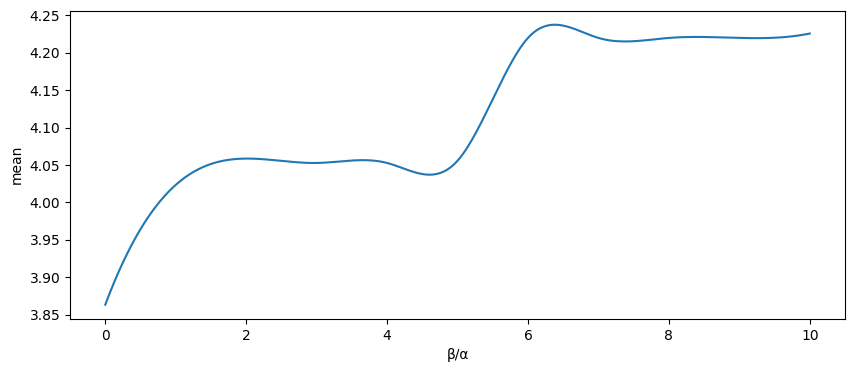

In [250]:
x = []
y = []
for i in results:
    x.append(i[0] / 243)
    y.append(i[1])

model = make_interp_spline(x, y)

xs = np.linspace(0, 10, 500)
ys = model(xs)
# xs = x
# ys = y

plt.figure(figsize=(10, 4))
plt.xlabel("β/α")
plt.ylabel("mean")
plt.plot(xs, ys)
plt.show()